In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install --upgrade pip
!pip install --upgrade "jax[cpu]"

In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib
import scipy.integrate as integrate
from scipy.stats import norm
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.dpi'] = 100

import itertools
from tqdm import tqdm

import jax
jax.config.update('jax_platform_name', 'cpu')

import pickle
import cvxpy as cvx

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from aaai_helpers.optim import *
from aaai_helpers.jax_spm import *
from aaai_helpers.eval import *
from aaai_helpers.utils import *
from aaai_helpers.baselines import *

Private data

In [7]:
with open('priv_data_1d_70d_3pols.pickle', 'rb') as f:
    priv_data = pickle.load(f)

In [13]:
mu_0_train = priv_data['train']['mu']
Sigma_0_train = priv_data['train']['Sigma']

mu_0_test = priv_data['test']['mu']
Sigma_0_test = priv_data['test']['Sigma']

nbucket, npol = mu_0_train.shape

greedy_alloc = greedy_1d(mu_0_train)

In [14]:
mu_0_train, Sigma_0_train

(array([[ 0.00000000e+00, -1.75326536e-02,  1.61324350e-02],
        [ 0.00000000e+00, -1.92229358e-03,  1.18644744e-03],
        [ 0.00000000e+00, -2.65536162e-03,  1.97428788e-03],
        [ 0.00000000e+00, -2.85430215e-03,  2.19957783e-03],
        [ 0.00000000e+00, -1.05373503e-02,  5.58063021e-03],
        [ 0.00000000e+00, -2.71689623e-03,  1.34245267e-03],
        [ 0.00000000e+00,  1.41502845e-03,  8.96459760e-04],
        [ 0.00000000e+00, -1.46661978e-03,  7.24525898e-06],
        [ 0.00000000e+00, -1.14460687e-03,  6.98381879e-04]]),
 array([[0.00000000e+00, 5.12992040e-08, 8.58710274e-09],
        [0.00000000e+00, 6.62001487e-08, 1.77838568e-08],
        [0.00000000e+00, 2.64499972e-08, 5.48900935e-09],
        [0.00000000e+00, 2.35614466e-07, 1.19678337e-08],
        [0.00000000e+00, 1.04178220e-06, 2.65922605e-07],
        [0.00000000e+00, 1.42582687e-07, 3.45004147e-08],
        [0.00000000e+00, 1.02870194e-05, 4.93589511e-08],
        [0.00000000e+00, 5.04250535e-07, 8.

In [15]:
ref_col = 0

total_ref_train = np.sum(np.array(mu_0_train)[:,ref_col])
total_ref_test = np.sum(np.array(mu_0_test)[:,ref_col])

In [16]:
### for hard bruteforce
candidates = [list(comb) for comb in list(itertools.product([0., 1.], repeat=npol)) if sum(comb) == 1]
all_hard_allocs = np.array(list(itertools.product(candidates, repeat=nbucket)))

### psi_0s for SuccessProbaMax
psi_0s = jnp.array([random.dirichlet(random.PRNGKey(i*23563), np.ones(npol), shape=(nbucket,)) for i in range(50000)])

In [17]:
### Define r (success region) with AB test interpretation
r_pct_range = np.arange(0.01,0.0365,0.0001)
# Rs_train = total_ref_train * (1 + r_pct_range)
# Rs_test = total_ref_test * (1 + r_pct_range)
Rs_train = r_pct_range ### rel diff
Rs_test = r_pct_range ### rel diff

methods = ['Bruteforce', 'Greedy1D', 'SuccessProbaMax']
res_1d_train = {i:np.zeros_like(Rs_train) for i in methods}
res_1d_test = {i:np.zeros_like(Rs_test) for i in methods}

In [21]:
for i in tqdm(range(len(Rs_train))):
    
    hard_bf_alloc = hard_bruteforce_1d_v3(all_hard_allocs, mu_0_train, Sigma_0_train, Rs_train[i])
    res_1d_train['Bruteforce'][i] = evaluate_1d_v2(hard_bf_alloc, mu_0_train, Sigma_0_train, Rs_train[i])
    res_1d_test['Bruteforce'][i] = evaluate_1d_v2(hard_bf_alloc, mu_0_test, Sigma_0_test, Rs_test[i])
    
    res_1d_train['Greedy1D'][i] = evaluate_1d_v2(greedy_alloc, mu_0_train, Sigma_0_train, Rs_train[i])
    res_1d_test['Greedy1D'][i] = evaluate_1d_v2(greedy_alloc, mu_0_test, Sigma_0_test, Rs_test[i])
    
    ### initial allocation to start SPM from 
    # psi_0 = np.array([[1./npol]*npol]*nbucket) ### uniform allocation
    # psi_0 = greedy_alloc
    # spm_alloc = optimize_1d(Sigma_0_train, mu_0_train, Rs_train[i], psi_0, n_steps=100000, eta = 0.01)
    
    spm_alloc = optimize_1d_v2(Sigma_0_train, mu_0_train, Rs_train[i], psi_0s, n_steps=100000, eta = 0.01)
    res_1d_train['SuccessProbaMax'][i] = evaluate_1d_v2(spm_alloc, mu_0_train, Sigma_0_train, Rs_train[i])
    res_1d_test['SuccessProbaMax'][i] = evaluate_1d_v2(spm_alloc, mu_0_test, Sigma_0_test, Rs_test[i])

100%|██████████| 265/265 [02:57<00:00,  1.49it/s]


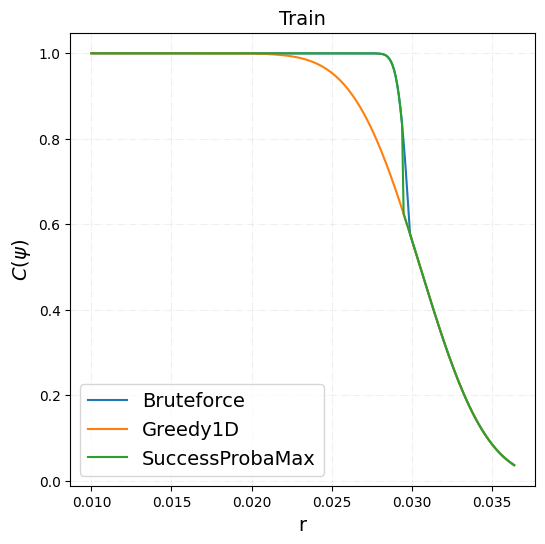

In [22]:
plt.figure(figsize=(6,6))
fontsize = 14

for m in methods[:]:
    plt.plot(
        Rs_train,
        res_1d_train[m],
        label=m
    )
    
plt.xlabel('r', fontsize=fontsize)
plt.ylabel('$C(\psi)$', fontsize=fontsize)
plt.grid(alpha=0.2, ls="-.")
plt.title('Train', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

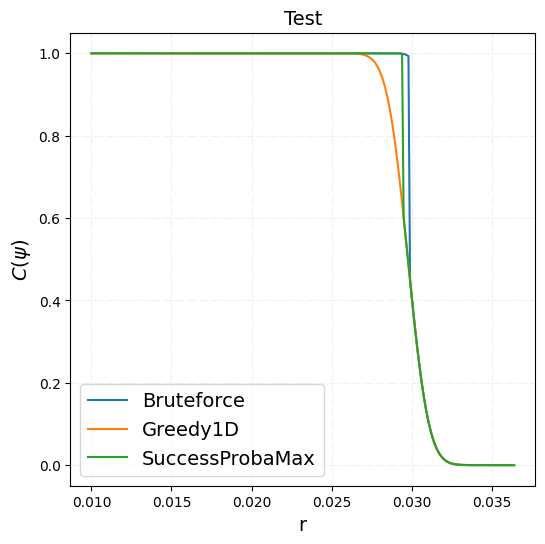

In [23]:
plt.figure(figsize=(6,6))
fontsize = 14

for m in methods[:]:
    plt.plot(
        Rs_test,
        res_1d_test[m],
        label=m
    )
    
plt.xlabel('r', fontsize=fontsize)
plt.ylabel('$C(\psi)$', fontsize=fontsize)
plt.grid(alpha=0.2, ls="-.")
plt.title('Test', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()